In [1]:
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft2, fft2, fftshift
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

%matplotlib inline

def opt_plot():
    plt.grid(True, linestyle = ':', color = '0.50')
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = 15
    plt.minorticks_on()
    plt.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    plt.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)
    
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext version_information
%version_information Matplotlib, Numpy, Scipy

Software versions
Python 3.9.2 64bit [MSC v.1928 64 bit (AMD64)]
IPython 7.25.0
OS Windows 10 10.0.19041 SP0
Matplotlib 3.4.2
Numpy 1.26.1
Scipy 1.11.3
Sun Nov 19 20:02:05 2023 Hora oficial do Brasil

## TESTE PARA 25m CONSERVANDO TOTAL DE 50% DOS TRAÇOS

In [3]:
def importando_dado(amostras, endereço):
    
    dado = np.fromfile(endereço, dtype='float32')
    nrecs = dado.size // amostras
    sismograma = dado.reshape(nrecs, amostras).T
    
    return sismograma

In [4]:
end = r'C:\Users\Matheus\Trabalhos e Estudos\TCCresults\toy2023_rp50m_pml.bin'
sismograma_pml = importando_dado(1251, end)

In [5]:
end_vel = r'C:\Users\Matheus\Trabalhos e Estudos\TCCresults\toy2023_cp.bin'
modelo_de_velocidade_pml = importando_dado(401, end_vel)

In [6]:
end_fonte = r'C:\Users\Matheus\Trabalhos e Estudos\TCCresults\wavelet_16Hz.bin'
fonte = np.fromfile(end_fonte, dtype='float32')

In [7]:
Nz =  401
Nt = sismograma_pml.shape[0]
Nx = sismograma_pml.shape[1]

Tempo = 5 #Tempo em segundos
T = Tempo/Nt #Período de amostragem temporal

dist_entre_recep = 50 #Distância entre receptores em metros
extencao_lateral = dist_entre_recep*(Nx-1)
extencao_profundidade = dist_entre_recep*(Nz-1)

tracos = range(1,Nx+1)

freq_ite = np.linspace(0, 1/T, Nt)
num_onda = np.linspace(-(np.pi)/dist_entre_recep, (np.pi)/dist_entre_recep, Nx)

amostras_temporais = np.linspace(0,Tempo,Nt)
amostragem_espacial = np.linspace(0, extencao_lateral , Nx)
amostragem_profundidade = np.linspace(0, extencao_profundidade, Nz)

In [8]:
print(Nx)

121


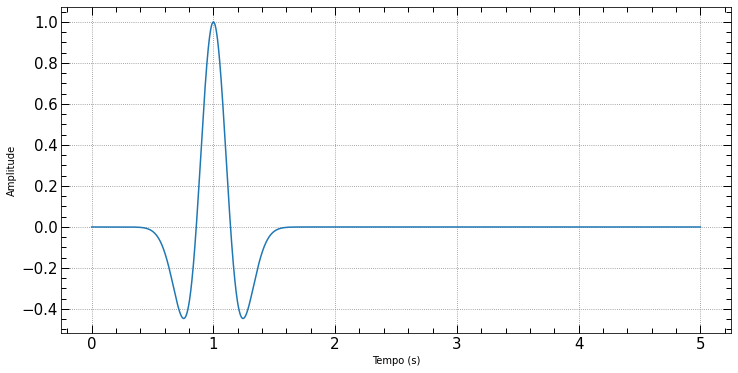

In [9]:
plt.figure(figsize = (12,6))
plt.plot(np.linspace(0,Tempo,len(fonte)), fonte)
plt.ylabel('Amplitude')
plt.xlabel('Tempo (s)')
opt_plot()
plt.savefig('Sinal-fonte-cap4.jpg')
plt.show()

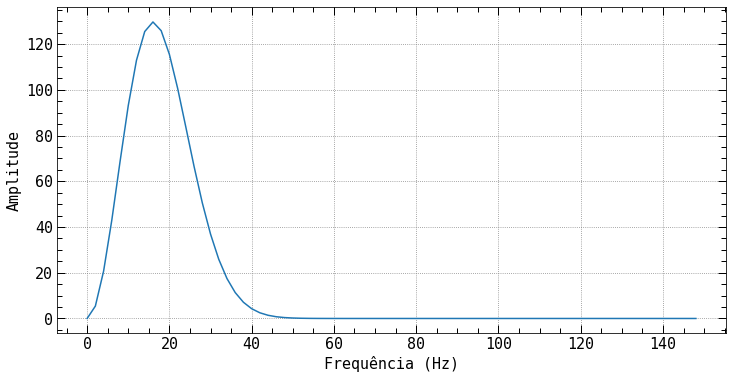

In [10]:
plt.figure(figsize = (12,6))
plt.plot(np.linspace(0, 1/0.0002, 2501)[0:75], abs(fft(fonte))[0:75])
plt.ylabel('Amplitude')
plt.xlabel('Frequência (Hz)')
opt_plot()
plt.savefig('fk-fonte-cap4.jpg')
plt.show()

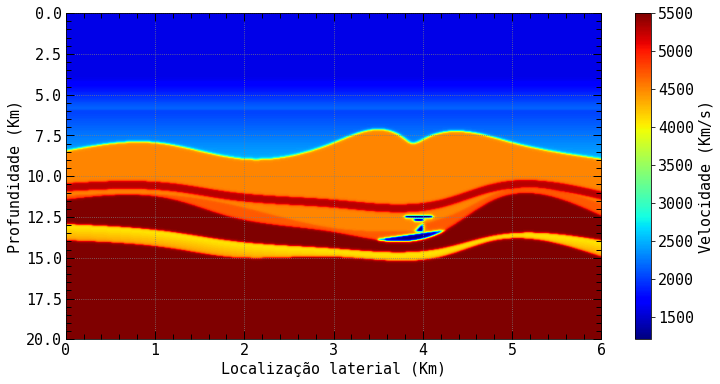

In [11]:
plt.figure(figsize = (12,6))
plt.imshow(modelo_de_velocidade_pml, extent=[amostragem_espacial[0]/1000,amostragem_espacial[Nx-1]/1000, amostragem_profundidade[Nz-1]/1000,amostragem_profundidade[0]/1000],
           aspect='auto', origin='upper', cmap='jet')
plt.ylabel('Profundidade (Km)')
plt.xlabel('Localização laterial (Km)')
plt.colorbar(label='Velocidade (Km/s)')
opt_plot()
plt.savefig('modelo-de-velocidade_pml-reto.jpg')
plt.show()

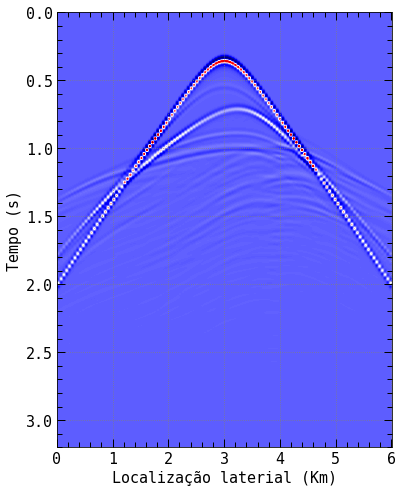

In [12]:
plt.figure(figsize = (6,8))
plt.imshow(sismograma_pml[0:800,:],extent=[amostragem_espacial[0]/1000,amostragem_espacial[Nx-1]/1000,amostras_temporais[800],amostras_temporais[0]],
           aspect='auto', origin='upper', cmap='seismic')
plt.ylabel('Tempo (s)')
plt.xlabel('Localização laterial (Km)')
opt_plot()
plt.savefig('sismograma-original_pml50-reto.jpg')
plt.show()

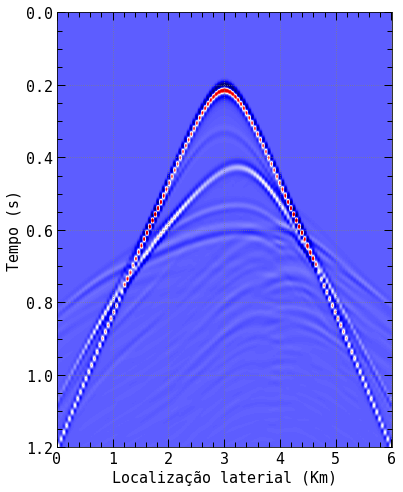

In [13]:
plt.figure(figsize = (6,8))
plt.imshow(sismograma_pml[0:500,:],extent=[amostragem_espacial[0]/1000,amostragem_espacial[Nx-1]/1000,amostras_temporais[300],amostras_temporais[0]],
           aspect='auto', origin='upper', cmap='seismic')
plt.ylabel('Tempo (s)')
plt.xlabel('Localização laterial (Km)')
opt_plot()
plt.savefig('sismograma-original_pml50-reto.jpg')
plt.show()

In [14]:
freq_sample = fft(sismograma_pml[:,100], norm='forward')

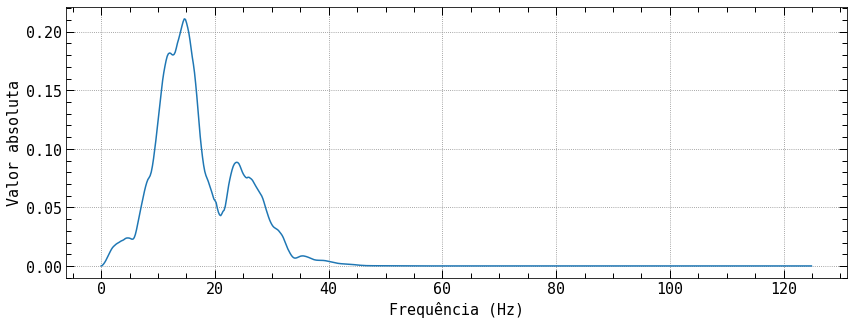

In [15]:
plt.figure(figsize=(14,5))
plt.plot(freq_ite[0:Nt//2], abs(freq_sample[0:Nt//2]))
plt.ylabel('Valor absoluta')
plt.xlabel('Frequência (Hz)')
opt_plot()
plt.savefig('Frequência-máxima-do-dado_pml50-reto.jpg')
plt.show()

In [16]:
fk_domain = fftshift(fft2(sismograma_pml, norm='ortho'), axes=-1)

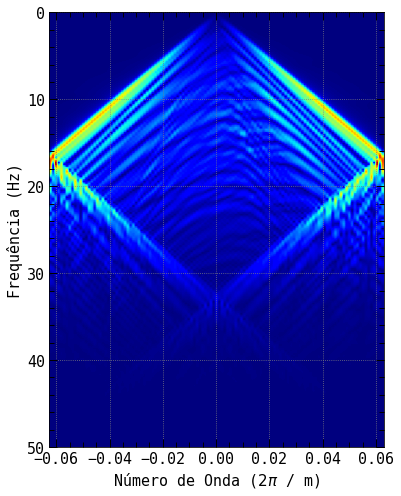

In [17]:
plt.figure(figsize = (6,8))
plt.imshow(abs(fk_domain[0:250,:]),extent=[num_onda[0],num_onda[Nx-1],freq_ite[250],freq_ite[0]], aspect='auto',
                origin='upper', cmap='jet')
plt.ylabel('Frequência (Hz)')
plt.xlabel('Número de Onda ($2\pi$ / m)')
opt_plot()
plt.savefig("Espectro-fk_pml50-reto.jpg")
plt.show()

In [18]:
def MPFI(dictionary, y , epsilon):

    r = y
    num_ite = 0
    size_col_dictionary = dictionary.shape[1]
    indices = np.array([])
    x = np.zeros(( size_col_dictionary ,), complex)

    while ( np.linalg.norm(r , ord=2) >= epsilon ) and (num_ite < 3000):
        
        absolute_fourier_domain = abs(np.dot(dictionary.T, r)) # Indo para o espaço da transformada

        max_freq_fourier_domain = max(absolute_fourier_domain) # Pegando a frequência com maior valor absoluto

        indices = np.where( absolute_fourier_domain == max_freq_fourier_domain )[0]

        atoms_selected = dictionary[:, indices]

        coef_max_value = np.dot(atoms_selected.T, r) 

        x[ indices ] = x[ indices ] + coef_max_value # Guardando as frequências
        r = r - np.dot(coef_max_value, len(y)*np.conjugate(atoms_selected.T)) # Atualizando o sinal
        #print(np.linalg.norm(r , ord=2))
        num_ite+=1
    
    return x

In [19]:
def Matriz_Transformada(Nk, pontos_normalizados):
    
    Np = len(pontos_normalizados)
    F = np.zeros((Nk,Np), complex)
    
    for k in range(Nk):
        for n in range(Np):
            F[k, n] = (1/Np)*np.exp(-2j*np.pi*k*pontos_normalizados[n])
    
    return F

def Matriz_Transformada_inversa(Nk, pontos_normalizados):
    
    Np = len(pontos_normalizados)
    iF = np.zeros((Np,Nk), complex)
    
    for k in range(Nk):
        for n in range(Np):
            iF[n, k] = np.exp(2j*np.pi*k*pontos_normalizados[n])
    
    return iF

In [20]:
def Decimando_aleatoriamente(sismograma_original, amostragem_original, tracos_original, porcent_max):

    tracos_decimado = []

    num = int(porcent_max*len(tracos_original)) 
    tracos_decimado = np.sort(random.sample(range(1,len(tracos_original)+1), num))
    #tracos_decimado = np.unique(np.sort(tracos_decimado))

    novo_sismograma, sismograma_decimado, amostragem_decimada = retirando_tracos_nulos(sismograma_original, amostragem_original,tracos_decimado)

    return novo_sismograma, sismograma_decimado, amostragem_decimada

def retirando_tracos_nulos(sismograma_original, amostragem_original, tracos_decimado):

    sismograma_decimado = np.zeros(sismograma_original.shape, float)
    amostragem_decimada = np.zeros(sismograma_original.shape[1], float)

    for i in range(len(tracos_decimado)):
        if tracos_decimado[i] == 121:
            sismograma_decimado[:,tracos_decimado[i]-1] = sismograma_original[:,tracos_decimado[i]-1]
        else:
            sismograma_decimado[:,tracos_decimado[i]] = sismograma_original[:,tracos_decimado[i]]

    for i in range(len(tracos_decimado)):
        if tracos_decimado[i] == 121:
            amostragem_decimada[tracos_decimado[i]-1] = amostragem_original[tracos_decimado[i]-1]
        else:    
            amostragem_decimada[tracos_decimado[i]] = amostragem_original[tracos_decimado[i]]


    index = []
    for i in range(sismograma_original.shape[1]):
        n = 0
        for t in range(sismograma_original.shape[0]):
            if sismograma_decimado[t,i] == 0:
                n+=1
        if n == sismograma_original.shape[0]:
              index.append(i)

    novo_sismograma = np.delete(sismograma_decimado, index, axis=1)

    index = []
    '''if tracos_decimado[0] != 0:
        for i in range(sismograma_original.shape[1]):
            if amostragem_decimada[i] == 0:
                index.append(i)
    else:'''
    for i in range(sismograma_original.shape[1]):
        if amostragem_decimada[i] == 0:
            index.append(i)

    amostragem_decimada = np.delete(amostragem_decimada, index)

    return novo_sismograma, sismograma_decimado, amostragem_decimada

In [37]:
porcent = 0.50 # Porcentagem de pontos conservados
novo_sismograma, sismograma_decimado, amostragem_decimada = Decimando_aleatoriamente(sismograma_pml, 
                                                                                              amostragem_espacial, 
                                                                                              tracos, 
                                                                                              porcent)

In [38]:
gap_max = []
for i in range(len(amostragem_decimada)-1):
    gap_max.append(amostragem_decimada[i+1] -amostragem_decimada[i])
print(max(gap_max))

300.0


In [39]:
len(amostragem_decimada)

60

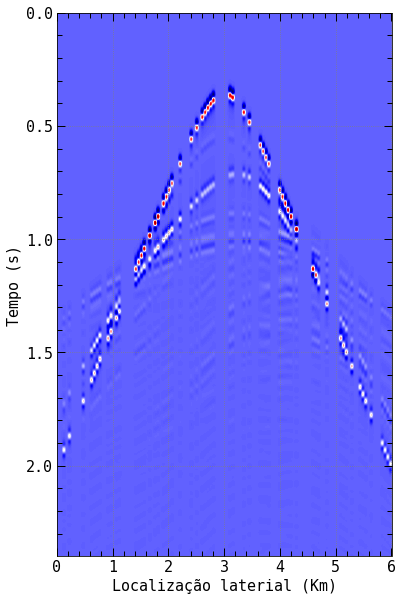

In [40]:
plt.figure(figsize = (6,10))
plt.imshow(sismograma_decimado[0:600,:],extent=[amostragem_espacial[0]/1000,amostragem_espacial[Nx-1]/1000,amostras_temporais[600],amostras_temporais[0]],
           aspect='auto', origin='upper', cmap='seismic')
plt.ylabel('Tempo (s)')
plt.xlabel('Localização laterial (Km)')
opt_plot()
plt.savefig(f'sismograma-decimado_pml50-reto-cap4.jpg')
plt.show()

In [41]:
espc_dado_decimado = fftshift(fft2(sismograma_decimado, norm='ortho'), axes = -1)

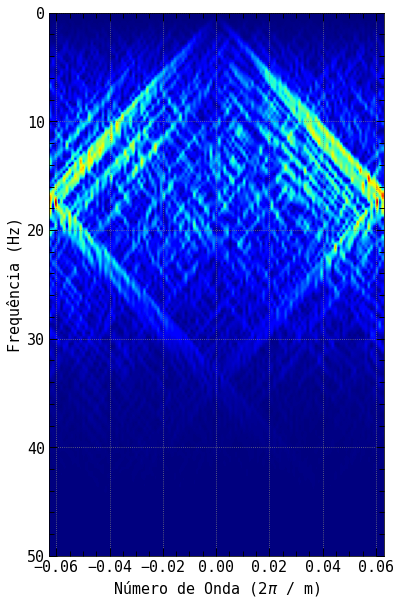

In [42]:
plt.figure(figsize = (6,10))
plt.imshow(abs(espc_dado_decimado[0:250,:]),extent=[num_onda[0],num_onda[Nx-1],freq_ite[250],freq_ite[0]], aspect='auto',
                origin='upper', cmap='jet')
plt.ylabel('Frequência (Hz)')
plt.xlabel('Número de Onda ($2\pi$ / m)')
opt_plot()
plt.savefig(f'FK-do-decimado_pml50-reto-cap4.jpg')
plt.show()

In [43]:
F_ndft = Matriz_Transformada(Nx, amostragem_decimada/extencao_lateral)

In [44]:
tol = 0.001

novo_espec_mp = np.zeros((Nt,Nx), complex)
fx_espec = fft2(novo_sismograma, axes=(0,), norm='ortho')

with tqdm(total=220) as progressing_load:
    for i in range(220):
        novo_espec_mp[i,:] = MPFI(F_ndft.T, fx_espec[i,:], tol)
        progressing_load.update(1)

100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:10<00:00, 21.70it/s]


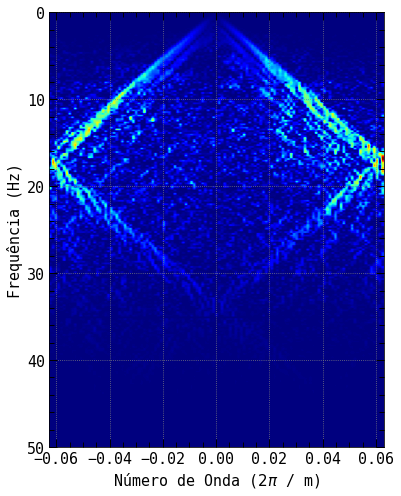

In [45]:
plt.figure(figsize = (6,8))
plt.imshow(abs(fftshift(novo_espec_mp, axes=-1))[0:250,:],extent=[num_onda[0],num_onda[Nx-1],freq_ite[250],freq_ite[0]], aspect='auto',
                origin='upper', cmap='jet')
plt.ylabel('Frequência (Hz)')
plt.xlabel('Número de Onda ($2\pi$ / m)')
opt_plot()
plt.savefig(f"FK-recuperado-pelo-MP_pml50-reto-cap4.jpg")
plt.show()

In [46]:
iFx = Matriz_Transformada_inversa(Nx, amostragem_espacial/extencao_lateral)
sismograma_interpolado_mp = ifft2(np.dot(novo_espec_mp, iFx.T), axes = (0,), norm = 'ortho').real

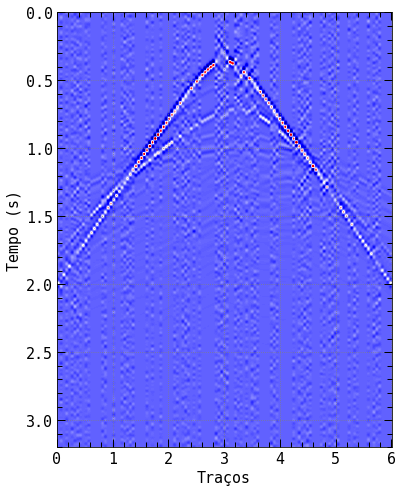

In [47]:
plt.figure(figsize = (6,8))
plt.imshow(2*sismograma_interpolado_mp[0:800,:],extent=[amostragem_espacial[0]/1000,amostragem_espacial[Nx-1]/1000,amostras_temporais[800],amostras_temporais[0]],
           aspect='auto', origin='upper', cmap='seismic')
plt.ylabel('Tempo (s)')
plt.xlabel('Traços')
opt_plot()
plt.savefig(f'sismograma-interpoaldo_pml50-reto-cap4.jpg')
plt.show()

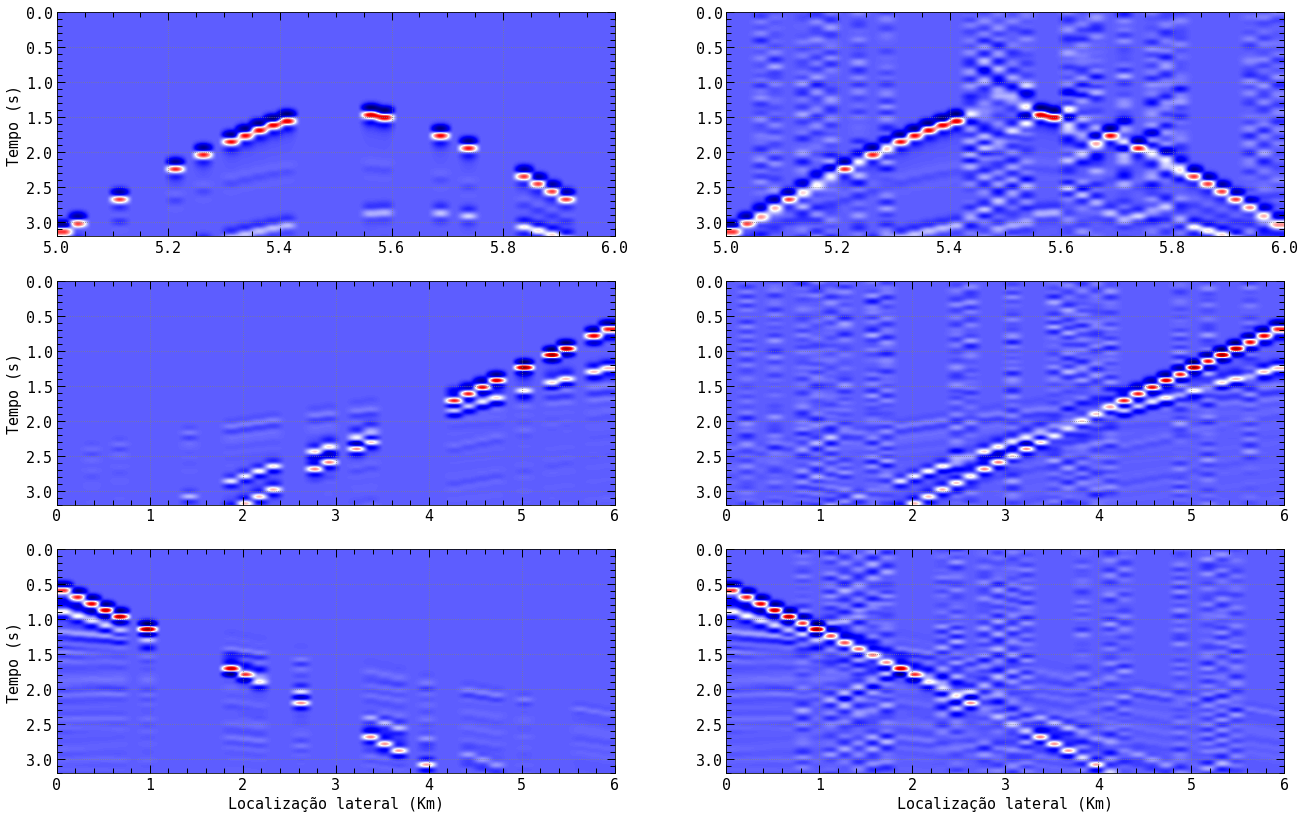

In [48]:
dados = np.array([[sismograma_decimado], [2*sismograma_interpolado_mp]])

plt.figure(figsize=(22,14))
for i in range(6):
    if i < 2:
        plt.subplot(3,2,i+1)
        plt.imshow(dados[i, 0,0:200, 40:80], vmax = np.max(sismograma_pml), vmin = np.min(sismograma_pml),
                   extent=[amostragem_espacial[100]/1000,amostragem_espacial[Nx-1]/1000,amostras_temporais[800],amostras_temporais[0]],
                aspect = 'auto', origin = 'upper', cmap = 'seismic')
        if i == 0:
            plt.ylabel('Tempo (s)')
    elif i >= 2 and i<4:
        plt.subplot(3,2,i+1)
        plt.imshow(dados[i-2, 0, 150:400, 0:40], vmax = np.max(sismograma_pml), vmin = np.min(sismograma_pml),
                 extent=[amostragem_espacial[0]/1000,amostragem_espacial[Nx-1]/1000,amostras_temporais[800],amostras_temporais[0]],
                   aspect = 'auto', origin = 'upper', cmap = 'seismic')
        if i == 2:
            plt.ylabel('Tempo (s)')
    elif i >= 4:
        plt.subplot(3,2,i+1)
        plt.imshow(dados[i-4, 0, 150:400, 80:120], vmax = np.max(sismograma_pml), vmin = np.min(sismograma_pml),
                   extent=[amostragem_espacial[0]/1000,amostragem_espacial[Nx-1]/1000,amostras_temporais[800],amostras_temporais[0]],
                   aspect = 'auto', origin = 'upper', cmap = 'seismic')
        if i == 4:
            plt.ylabel('Tempo (s)')
        plt.xlabel('Localização lateral (Km)')
    opt_plot()
plt.savefig(f"dado-interpolado-x-decimado-50pml-cap4.jpg")
plt.show()

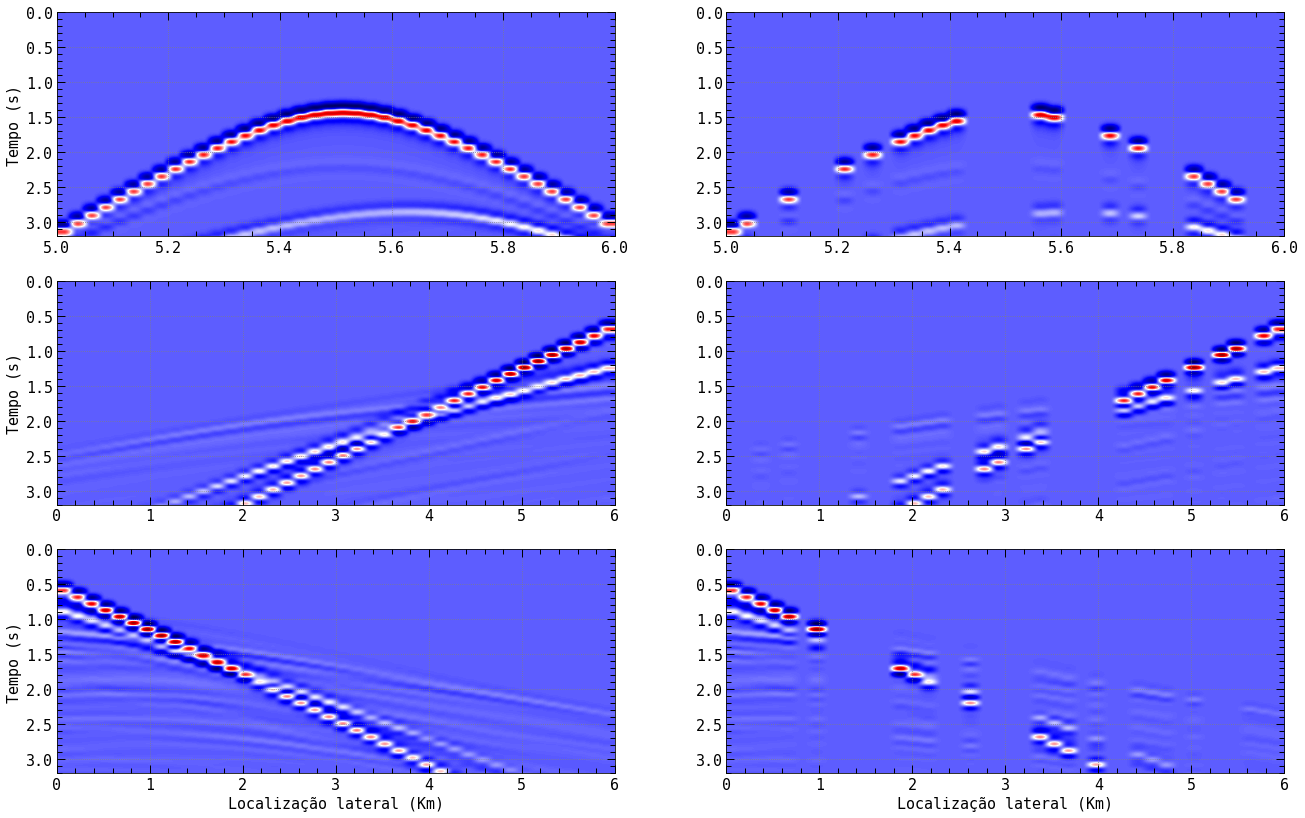

In [49]:
dados = np.array([[sismograma_pml], [sismograma_decimado]])

plt.figure(figsize=(22,14))
for i in range(6):
    if i < 2:
        plt.subplot(3,2,i+1)
        plt.imshow(dados[i, 0,0:200, 40:80], vmax = np.max(sismograma_pml), vmin = np.min(sismograma_pml),
                   extent=[amostragem_espacial[100]/1000,amostragem_espacial[Nx-1]/1000,amostras_temporais[800],amostras_temporais[0]],
                aspect = 'auto', origin = 'upper', cmap = 'seismic')
        if i == 0:
            plt.ylabel('Tempo (s)')
    elif i >= 2 and i<4:
        plt.subplot(3,2,i+1)
        plt.imshow(dados[i-2, 0, 150:400, 0:40], vmax = np.max(sismograma_pml), vmin = np.min(sismograma_pml),
                 extent=[amostragem_espacial[0]/1000,amostragem_espacial[Nx-1]/1000,amostras_temporais[800],amostras_temporais[0]],
                   aspect = 'auto', origin = 'upper', cmap = 'seismic')
        if i == 2:
            plt.ylabel('Tempo (s)')
    elif i >= 4:
        plt.subplot(3,2,i+1)
        plt.imshow(dados[i-4, 0, 150:400, 80:120], vmax = np.max(sismograma_pml), vmin = np.min(sismograma_pml),
                   extent=[amostragem_espacial[0]/1000,amostragem_espacial[Nx-1]/1000,amostras_temporais[800],amostras_temporais[0]],
                   aspect = 'auto', origin = 'upper', cmap = 'seismic')
        if i == 4:
            plt.ylabel('Tempo (s)')
        plt.xlabel('Localização lateral (Km)')
    opt_plot()
plt.savefig(f"dado-interpolado-x-decimado-50pml-cap4.jpg")
plt.show()

In [53]:
def RMSE(sismograma, sismograma_interpolado):
    Nx = sismograma.shape[1]
    #rsme = np.zeros(Nx)
    #for trc in range(Nx):
    rsme = np.linalg.norm(sismograma[:,:] - sismograma_interpolado[:,:])/np.linalg.norm(sismograma[:,:])
    return rsme

def SNR(sismograma, sismograma_interpolado):
    Nx = sismograma.shape[1]
    #snr = np.zeros(Nx)
    #for trc in range(Nx):
    snr = 10*np.log10(np.linalg.norm(sismograma[:,:])/np.linalg.norm(abs(sismograma[:,:] - sismograma_interpolado[:,:])))
    return snr

In [54]:
print(RMSE(sismograma_pml, 2*sismograma_interpolado_mp)*100)

78.6707004164942


In [55]:
print(SNR(sismograma_pml, 2*sismograma_interpolado_mp))

1.0418698322778848
